In [1]:
#先引入后面可能用到的包（package）
import pandas as pd  
from datetime import datetime
import backtrader as bt
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

# 数据准备

In [2]:
import tushare as ts
token='f6b511d8d4529f19319e1861edadda749e64a5b8573102deec80cfd8'
pro=ts.pro_api(token)

In [3]:
import tushare as ts
def get_data(code,date='20200101'):
    data1=ts.pro_bar(ts_code=code, adj='qfq', start_date=date)
    data1=data1[['trade_date','open','high','low','close','vol']]
    data2=pro.daily_basic(ts_code=code,fields='trade_date,turnover_rate,pe,pb')
    data=pd.merge(data1,data2,on='trade_date')
    data.index=pd.to_datetime(data.trade_date)
    data=data.sort_index()
    data['volume']=data.vol
    data['openinterest']=0
    data['datetime']=pd.to_datetime(data.trade_date)
    data=data[['datetime','open','high','low','close',\
               'volume','openinterest','turnover_rate','pe','pb']]
    data=data.fillna(0)
    return data

In [101]:
#数据保存到本地
get_data('300002.SZ').to_csv('test.csv',index=False)
get_data('300002.SZ').head()

,datetime,open,high,low,close,volume,openinterest,turnover_rate,pe,pb
trade_date,,,,,,,,,,
2020-01-02,2020-01-02,3.30,3.37,3.26,3.36,307949.39,0,2.1763,82.1117,1.3373
2020-01-03,2020-01-03,3.37,3.41,3.35,3.39,266667.20,0,1.8845,82.8449,1.3492
2020-01-06,2020-01-06,3.35,3.49,3.34,3.45,315023.58,0,2.2263,84.3112,1.3731
2020-01-07,2020-01-07,3.46,3.65,3.46,3.60,577685.99,0,4.0825,87.9769,1.4328
2020-01-08,2020-01-08,3.57,3.63,3.52,3.54,426636.96,0,3.0150,86.5106,1.4089


# 扩展feeds中的数据加载

In [5]:
#pandas的数据格式
import backtrader as bt
from backtrader.feeds import PandasData
class Addmoredata(PandasData):
    lines = ('turnover_rate','pe','pb',)
    params = (('turnover_rate',7),('pe',8),('pb',9),)

In [91]:
#直接读取本地csv格式数据
from backtrader.feeds import GenericCSVData
class AddCsvData(GenericCSVData):
    lines = ('turnover_rate','pe','pb',)
    params = (('turnover_rate',7),('pe',8),('pb',9),)

## 添加其他数据——单只股票

In [96]:
class TestStrategy1(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def next(self):
        self.log(f"换手率:{self.datas[0].turnover_rate[0]},市净率:{self.datas[0].pb[0]},市盈率:{self.datas[0].pe[0]}")

In [100]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy1)
feed = Addmoredata(dataname = get_data('300002.SZ','20200420'))
#如果是读取csv数据使用下式
#feed = AddCsvData(dataname = 'test.csv',dtformat=('%Y-%m-%d'))
cerebro.adddata(feed)
cerebro.run()

2020-04-20, 换手率:20.8743,市净率:3.3256,市盈率:158.3584
2020-04-21, 换手率:16.503,市净率:2.992,市盈率:142.4736
2020-04-22, 换手率:18.2413,市净率:3.2897,市盈率:156.6477
2020-04-23, 换手率:21.3831,市净率:3.0793,市盈率:146.6281
2020-04-24, 换手率:16.1957,市净率:3.1203,市盈率:148.5832
2020-04-27, 换手率:13.0385,市净率:2.874,市盈率:136.8529
2020-04-28, 换手率:10.3652,市净率:2.9355,市盈率:0.0
2020-04-29, 换手率:8.3977,市净率:2.797,市盈率:0.0
2020-04-30, 换手率:8.3719,市净率:2.8967,市盈率:0.0
2020-05-06, 换手率:9.4114,市净率:3.0462,市盈率:0.0
2020-05-07, 换手率:9.1606,市净率:3.013,市盈率:0.0


## 添加其他数据——多只股票

In [8]:
class TestStrategy2(bt.Strategy):
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def next(self):
        for data in self.datas:
            print(data._name)
            self.log(f"换手率:{data.turnover_rate[0]},市净率:{data.pb[0]},市盈率:{data.pe[0]}")

In [9]:
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy2)
codes=['600862.SH','300326.SZ','300394.SZ']
#加载最近两日交易数据
for code in codes:
    feed = Addmoredata(dataname = get_data(code,'20200506'),name=code)
    cerebro.adddata(feed)
cerebro.run()

600862.SH
2020-05-06, 换手率:3.3376,市净率:4.9646,市盈率:39.247
300326.SZ
2020-05-06, 换手率:1.8874,市净率:6.4762,市盈率:60.2625
300394.SZ
2020-05-06, 换手率:2.833,市净率:8.6431,市盈率:63.1617
600862.SH
2020-05-07, 换手率:1.8531,市净率:4.9486,市盈率:39.1208
300326.SZ
2020-05-07, 换手率:2.1378,市净率:6.5019,市盈率:60.5016
300394.SZ
2020-05-07, 换手率:2.7572,市净率:8.367,市盈率:61.1439


# 以换手率和市盈率构建交易策略示例

In [10]:
class MyStrategy(bt.Strategy):

    def next(self):
        if not self.position: # 没有持仓
            if self.datas[0].turnover_rate[0]<3 and 0<self.datas[0].pe[0]<50:
                # 得到当前的账户价值
                total_value = self.broker.getvalue()
                #1手=100股，满仓买入
                ss=int((total_value/100)/self.datas[0].close[0])*100
                self.order=self.buy(size=ss)
        else:
            if self.datas[0].turnover_rate[0]>10 or self.datas[0].pe[0]>80 :
                self.close(self.datas[0])

In [11]:
cerebro = bt.Cerebro()  
cerebro.addstrategy(MyStrategy)
feed = Addmoredata(dataname = get_data('300002.SZ','20050101'))
cerebro.adddata(feed)
startcash = 100000
cerebro.broker.setcash(startcash) 
cerebro.broker.setcommission(commission=0.001) 
cerebro.run()
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
#打印结果
print(f'期初总资金: {round(startcash,2)}')
print(f'期末总资金: {round(portvalue,2)}')
print(f'净收益: {round(pnl,2)}')

期初总资金: 100000
期末总资金: 303371.37
净收益: 203371.37


<IPython.core.display.Javascript object>


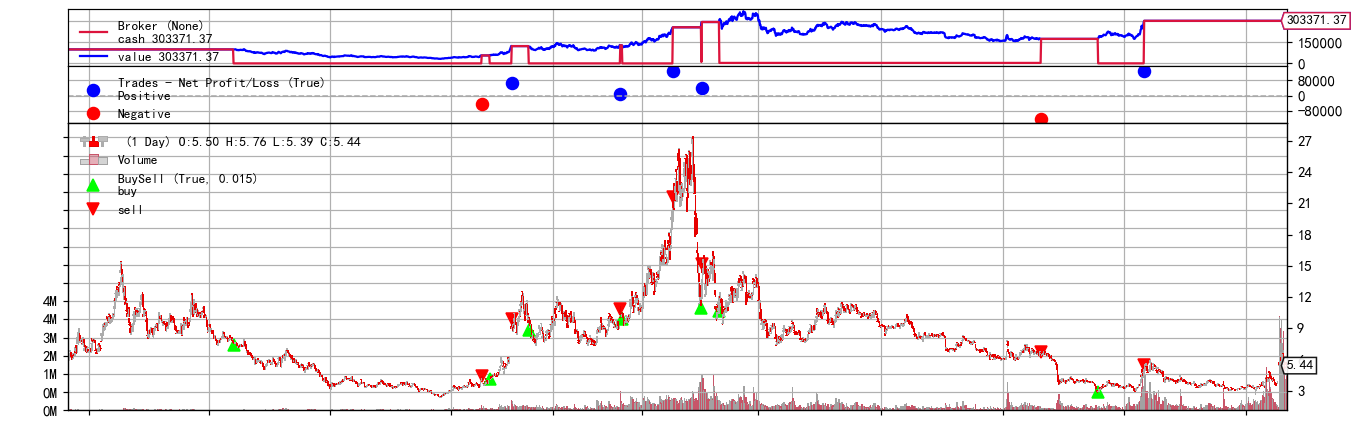

[[<Figure size 432x288 with 4 Axes>]]

In [12]:
%matplotlib inline 
cerebro.plot(style='candlestick')

In [14]:
data = Addmoredata(dataname = get_data('300002.SZ','20050101'))
#注意plot_result是自己写的扩展脚本加入backtrader安装文件里了
#下面直接导入使用
bt.plot_result(MyStrategy,data,startcash = 100000,commission=0.001)

将zjy_plot.py放在backtrader的安装文件夹下（我的路径是：Anaconda3\lib\site-packages\backtrader）,然后使用notepad+（网上下载用于查看py等文件）打开__init__.py文件，在最后加上一句：from .zjy_plot import * 。重新启动即可导入使用。

# 使用pyecharts0.5.11版本对策略指标可视化

In [64]:
#addmoredata是在PandasData上的扩展
#out_result是自己写的脚本zjy_plot.py里输出策略评价指标的函数
ddf=get_data('300002.SZ','20050101')
data = Addmoredata(dataname = ddf)
df00,df0,df1,df2,df3,df4=bt.out_result(MyStrategy,data,startcash = 100000,commission=0.001)

In [62]:
def kline_plot(df,name):
    #画K线图数据
    date = df.index.strftime('%Y%m%d').tolist()
    k_value = df[['open','close', 'low','high']].values
    #引入pyecharts画图使用的是0.5.11版本，新版命令需要重写
    kline = Kline(name+'行情走势')
    kline.add('日K线图', date, k_value,
              is_datazoom_show=True,is_splitline_show=False)
    #成交量
    bar = Bar()
    bar.add('成交量', date, df['volume'],tooltip_tragger='axis', 
                is_legend_show=False, is_yaxis_show=False, 
                yaxis_max=5*max(df['volume']))
    overlap = Overlap()
    overlap.add(kline)
    overlap.add(bar,yaxis_index=1, is_add_yaxis=True)
    return overlap    

In [65]:
kline_plot(ddf,'神州泰岳')

## 评价指标表格

In [18]:
df00

,绩效指标,绩效指标值,普通交易指标,普通交易指标值,多空交易指标,多空交易指标值
0,calmar_ratio,0.013,total_trade_num,7.0000,long_num,7.0000
1,average_drawdown_len,1085.000,total_trade_opened,0.0000,long_win_num,5.0000
2,average_drawdown_rate,18.370,total_trade_closed,7.0000,long_lost_num,2.0000
3,average_drawdown_money,68269.090,total_trade_len,1560.0000,long_total_pnl,203371.3691
4,max_drawdown_len,1085.000,long_trade_len,1560.0000,long_average_pnl,29053.0527
5,max_drawdown_rate,68.380,short_trade_len,0.0000,long_win_total_pnl,366620.1679
6,max_drawdown_money,213373.740,longest_win_num,4.0000,long_win_max_pnl,128547.0720
7,average_rate,0.260,longest_lost_num,1.0000,long_lost_total_pnl,-163248.7988
8,stddev_rate,0.730,net_total_pnl,203371.3691,long_lost_max_pnl,-120282.4741
9,positive_year,5.000,net_average_pnl,29053.0527,short_num,0.0000


## 账户价值、持仓市值和收益率

In [87]:
from pyecharts import*
def plot_result_py(data,v,title,plot_type='line',zoom=False):
    att=data.index
    try:
        attr=att.strftime('%Y%m%d')
    except:
        attr=att
    if plot_type=='line':
        p=Line(title)
        p.add('',attr,list(data[v].round(2)),
         is_symbol_show=False,line_width=2,
        is_datazoom_show=zoom,is_splitline_show=True)
    else:
        p=Bar(title)
        p.add('',attr,[int(i*1000)/10 for i in list(data[v])],
              is_label_show=True,
        is_datazoom_show=zoom,is_splitline_show=True)
    return p

In [88]:
plot_result_py(df0,'total_value','账户价值')

In [89]:
plot_result_py(df4,'total_position_value','持仓市值')

In [90]:
plot_result_py(df3,'year_rate','年化收益%',plot_type='bar')